# Text semplification project

## RNN model with Attention mechanism

**Authors**: 

*   Davide Mercanti: davide.mercanti@studio.unibo.it
*   Riccardo Fava: riccardo.fava6@studio.unibo.it
*   Luca Bompani: luca.bompani4@studio.unibo.it

## Configuration

In [ ]:
from utilities import resize
resize(100)

!pip install fasttext > /dev/null
!pip install "tensorflow-text==2.8.*" > /dev/null   

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
try:
    from keras.preprocessing.sequence import pad_sequences
except ImportError:
    from keras.utils import pad_sequences
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import word_tokenize
import fasttext
import fasttext.util
import typing
from typing import Any, Tuple
import tensorflow_text as tf_text
from os.path import join, dirname
try:
    from google.colab import drive
    COLAB = True
except ModuleNotFoundError:
    COLAB = False

from data_cleaning import clean_data
from data_preparation import build_vocabulary
    
from utilities import memoization, plot_trend

tf.config.run_functions_eagerly(True)

@memoization(0)
def word_tk_mem(arg):
    return word_tokenize(arg)

nltk.download('punkt')
if COLAB:
    drive.mount('/content/drive')
    PATH = '/content/drive/MyDrive/UniBO/NLP'
else:
    PATH = './'
use_builtins = True

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Mounted at /content/drive


## Pre-processing

In [ ]:
df = clean_data(PATH)
df.dropna(inplace=True)
df.head(15)

DF 1 has shape (63006, 2)
DF 2 has shape (1166, 2)


,sentence_1,sentence_2
0,ma questo a cosa servirebbe ?,a che servono queste cose ?
1,"salve, avrei bisogno di una informazione piutt...",ho bisogno di una informazione urgente .
2,ciao a tutti avrei bisogno di un consiglio .,ho bisogno di un suo consiglio .
3,possibilmente uno che avesse bisogno dell aiuto .,ho bisogno di un vostro aiuto .
4,questa sarebbe una cosa positiva.,questa era una nuova cosa .
5,possibilmente uno che avesse bisogno dell aiuto .,ho bisogno di un aiuto .
6,avrei bisogno di un aiuto .,ho bisogno di un vostro aiuto .
7,quale sarebbe allora la soluzione giusta ?,è questa la soluzione giusta ?
8,"salve , avrei bisogno di un vostro aiuto .",abbiamo bisogno del vostro aiuto .
9,"salve , avrei bisogno di un vostro aiuto .",ho bisogno del vostro aiuto .


In [ ]:
TRAIN_DF, TEST_DF = train_test_split(df, test_size=0.3)

In [ ]:
idx_to_word, word_to_idx, word_listing = build_vocabulary(TRAIN_DF, TEST_DF, word_tk_mem)
VOCAB_SIZE = len(word_listing)
print(VOCAB_SIZE)

17982


## Load Pre-trained Word embedding model

In [ ]:
EMBEDD_DIM = 200

EMBEDD_FNAME = f'cc.it.{EMBEDD_DIM}.bin'  #ex. 'cc.it.100.bin'

try: EMBEDDING_MODEL
except NameError:
    # Downloading FastText italian pre-trained model
    fasttext.FastText.eprint = lambda x: None
    try:
        print('Loading fasttext model...', flush=True)
        EMBEDDING_MODEL = fasttext.load_model(join(PATH, EMBEDD_FNAME))
    except ValueError as e:
        print(e)
        fasttext.util.download_model('it', if_exists='ignore')  
        EMBEDDING_MODEL = fasttext.load_model(join(PATH, EMBEDD_FNAME))

print(EMBEDDING_MODEL.get_dimension())

Loading fasttext model...
200


In [ ]:
def check_OOV_terms(embedding_model, vocabulary_terms):
  '''Returns a list of out-of-vocabulary (OOV) terms and the corresp. len'''
  oov = set(vocabulary_terms).difference(set(embedding_model.words))
  return list(oov), len(oov)

In [ ]:
_, n_oov_terms = check_OOV_terms(EMBEDDING_MODEL, word_listing)
print(f"Total OOV terms: {n_oov_terms} ({n_oov_terms*100/len(word_listing):.03f}%)")

Total OOV terms: 1285 (7.146%)


In [ ]:
EMBEDDING_DIM = EMBEDDING_MODEL.get_dimension()

def compute_embedding_matrix(embedding_model, idx_to_word):
  """
  Return the embedding matrix of the train vocabulary:
  """
  embedding_matrix = np.zeros((VOCAB_SIZE+1, EMBEDDING_DIM), dtype='float32')

  for idx in idx_to_word.keys():
    embedding_matrix[idx] = embedding_model.get_word_vector(idx_to_word[idx])
  return embedding_matrix

EMBEDDING_MATRIX = compute_embedding_matrix(EMBEDDING_MODEL, idx_to_word)

In [ ]:
print(f'Weights matrix size: {EMBEDDING_MATRIX.shape}')
print(f'Vocab size: {VOCAB_SIZE}')

Weights matrix size: (17983, 200)
Vocab size: 17982


In [ ]:
def word_to_idx_conversion(df, word_to_idx,len_sentence=None): 
  """
  Return input data (sentences) encoded and padded
  
  Parameters
  ----------
  - corpus (train or test dataframe)

  Return
  ------
  - DataFrame: sentences encoded using the word_to_idx dict and padded
  """
  # Conversion
  converted_df = df.applymap(lambda _: [word_to_idx[token] for token in word_tk_mem(_)])
  # Padding
  padded_df = converted_df
  return padded_df

ENCODED_TRAIN_DF = word_to_idx_conversion(TRAIN_DF, word_to_idx)
m_len_input=max([len(i) for i in ENCODED_TRAIN_DF['sentence_1']])
ENCODED_TEST_DF = word_to_idx_conversion(TEST_DF, word_to_idx,len_sentence=m_len_input)
print(ENCODED_TRAIN_DF.shape, ENCODED_TEST_DF.shape)
ENCODED_TRAIN_DF.head(3)

(44918, 2) (19251, 2)


,sentence_1,sentence_2
15225,"[12537, 5474, 866, 3224, 10136, 6097, 500]","[14233, 12537, 5474, 3224, 10136, 6097, 500]"
32569,"[4241, 2982, 3224, 11529, 6097, 2094, 500]","[4241, 2982, 3224, 7614, 2094, 500]"
60145,"[9191, 5751, 9483, 8645, 13209, 4041, 1008, 500]","[5751, 9483, 5485, 8645, 13209, 500]"


In [ ]:
def train_gen():
  """
  Generator that apply the same padding to the same complex-simplified
  couple of sentences, returning them. 
  """
  complex_sentences = [list(i) for i in ENCODED_TRAIN_DF['sentence_1'].values] 
  simple_sentences =[list(i) for i in ENCODED_TRAIN_DF['sentence_2'].values] 
  for i, j in zip(complex_sentences, simple_sentences):
    max_len = max([len(i),len(j)])
    i = pad_sequences([i], padding="post", maxlen=max_len)
    j = pad_sequences([j], padding="post", maxlen=max_len)
    yield (tf.convert_to_tensor(i), tf.convert_to_tensor(j))

sentences_dataset = tf.data.Dataset.from_generator(generator = train_gen,
                                                  output_shapes=[2,1,None],
                                                  output_types=tf.int64
                                                  )


In [ ]:
"""
Defining the Train Dataset object using the bucket_by_sequence_lenght
in order to use the minimum padding length within each batch

"""
BATCH_SIZE = 1
BOUNDARIES = [5, 10, 15, 25, 35, 50, 100]
N_BUCKETS = len(BOUNDARIES) + 1

TRAIN_DATASET = sentences_dataset.bucket_by_sequence_length(
        element_length_func = lambda x: tf.shape(x)[2]),
        bucket_boundaries = BOUNDARIES,
        bucket_batch_sizes=[BATCH_SIZE]*N_BUCKETS)

## Baseline model - RNN with attention mechanism

### Model definition and utility functions

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, input_vocab_size,embedding_matrix, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.input_vocab_size = input_vocab_size

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                               embedding_dim,
                                               embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                               mask_zero=True)

    # The GRU RNN layer processes those vectors sequentially.
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   # Return the sequence and state
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, tokens, state=None):
    # 2. The embedding layer looks up the embedding for each token.
    vectors = self.embedding(tokens)

    # 3. The GRU processes the embedding sequence.
    #    output shape: (batch, s, enc_units)
    #    state shape: (batch, enc_units)
    output, state = self.gru(vectors, initial_state=state)

    # 4. Returns the new sequence and its state.
    return output, state

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  """
  Implementation of the Bahdanau's additive attention.
  
  """
  def __init__(self, units):
    super().__init__()
    # For Eqn. (4), the  Bahdanau attention
    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)
    self.attention = tf.keras.layers.AdditiveAttention()
    
  def call(self, query, value, mask):
    # From Eqn. (4), `W1@ht`.
    w1_query = self.W1(query)

    # From Eqn. (4), `W2@hs`.
    w2_key = self.W2(value)

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        mask=[query_mask, value_mask],
        return_attention_scores = True,
    )
    return context_vector, attention_weights

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size,embedding_matrix, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim

    # For Step 1. The embedding layer convets token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                               embedding_dim,
                                               embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),mask_zero=True)

    # For Step 2. The RNN keeps track of what's been generated so far.
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # For step 3. The RNN output will be the query for the attention layer.
    self.attention = BahdanauAttention(self.dec_units)

    # For step 4. Eqn. (3): converting `ct` to `at`
    self.Wc = tf.keras.layers.Dense(dec_units//4, activation=tf.math.tanh,
                                    use_bias=False)

    # For step 5. This fully connected layer produces the logits for each
    # output token.
    self.fc = tf.keras.layers.Dense(self.output_vocab_size)
  
  def call(self,
          inputs: DecoderInput,
          state=None) -> Tuple[DecoderOutput, tf.Tensor]:

    # Step 1. Lookup the embeddings
    vectors = self.embedding(inputs.new_tokens)
    # Step 2. Process one step with the RNN
    rnn_output, state = self.gru(vectors, initial_state=state)

    # Step 3. Use the RNN output as the query for the attention over the
    # encoder output.
    context_vector, attention_weights = self.attention(
        query=rnn_output, value=inputs.enc_output, mask=inputs.mask)

    # Step 4. Eqn. (3): Join the context_vector and rnn_output
    #     [ct; ht] shape: (batch t, value_units + query_units)
    context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

    # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
    attention_vector = self.Wc(context_and_rnn_output)

    # Step 5. Generate logit predictions:
    logits = self.fc(attention_vector)

    #print(f'DEC ENDS with {type(logits)}, {type(attention_weights)}')
    return DecoderOutput(logits, attention_weights), state


"""
The call method of the Decoder takes and returns multiple tensors. 
Organize those into simple container classes:

"""
class DecoderInput(typing.NamedTuple):
  new_tokens: Any
  enc_output: Any
  mask: Any

class DecoderOutput(typing.NamedTuple):
  logits: Any
  attention_weights: Any

In [ ]:
class Simplifier(tf.keras.Model):
  def __init__(self, embedding_dim, embedding_matrix,units,
               vocabulary_size,
               use_tf_function=True):
    super().__init__()
    # Build the encoder and decoder
    self.encoder = Encoder(vocabulary_size, embedding_matrix,
                      embedding_dim, units)
    self.decoder = Decoder(vocabulary_size, embedding_matrix,
                      embedding_dim, units)
    self.use_tf_function = use_tf_function

  def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
    input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]
    # Run the decoder one step.
    decoder_input = DecoderInput(new_tokens=input_token,
                                enc_output=enc_output,
                                mask=input_mask)

    dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
    y = target_token
    y_pred = dec_result.logits
    step_loss = self.loss(y, y_pred)
    return step_loss, dec_state
 
  def call(self, inputs, training=False):
    ress = []
    mask = (inputs != 0)
    length = tf.shape(inputs)[-1]
    
    x, enc_state = self.encoder(inputs)
    dec_state = enc_state
    input_token = tf.expand_dims(inputs[:,-1],axis=0)
    for t in tf.range(length): #-1
        decoder_input = DecoderInput(
            new_tokens = input_token,
            enc_output = x,
            mask = mask  
        )
        dec_res, dec_state = self.decoder(decoder_input, state=dec_state)
        input_token=tf.math.argmax(dec_res.logits,axis=-1)
        ress.append((np.argmax(np.array(list(dec_res.logits))), np.max(np.array(list(dec_res.logits)))))  
    return ress
    
  def train_step(self, inputs):
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.int64, shape=[2,1,None])])
  def _tf_train_step(self, inputs):
    return self._train_step(inputs)
    

def _train_step(self, inputs):
    #input_text, target_text = inputs
    input_text, target_text = tf.squeeze(inputs, axis=0) 
    input_text, target_text = tf.expand_dims(input_text, axis=0), tf.expand_dims(target_text, axis=0)
    
    input_mask = input_text != 0
    target_mask = target_text != 0
    max_target_length = tf.math.minimum(tf.shape(input_text)[1],tf.shape(target_text)[1])
    with tf.GradientTape() as tape:
      # Encode the input
      enc_output, enc_state = self.encoder(input_text)

      # Initialize the decoder's state to the encoder's final state.
      # This only works if the encoder and decoder have the same number of
      # units.
      dec_state = enc_state
      loss = tf.constant(0.0)
      for t in tf.range(max_target_length-1):
        # Pass in two tokens from the target sequence:
        # 1. The current input to the decoder.
        # 2. The target for the decoder's next prediction.
        new_tokens = target_text[:, t:t+2]
        
        step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                              enc_output, dec_state)
        loss = loss + step_loss

      # Average the loss over all non padding tokens.
      average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

    # Apply an optimization step
    variables = self.trainable_variables 
    gradients = tape.gradient(average_loss, variables)
    self.optimizer.apply_gradients(zip(gradients, variables))

    # Return a dict mapping metric names to current value
    return {'batch_loss': average_loss}

Simplifier._train_step = _train_step

In [ ]:
class MaskedLoss(tf.keras.losses.Loss):
  """
  To avoid having the network overwhelmed by learning the padding we have introduced 
  a masked loss in order properly don't take it into consideration.
  
  """
  def __init__(self):
    self.name = 'masked_loss'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

  def __call__(self, y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss = self.loss(y_true, y_pred)
    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, tf.float32)
    loss *= mask
    # Return the total.
    return tf.reduce_sum(loss)


class BatchLogs(tf.keras.callbacks.Callback):
  def __init__(self, key):
    self.key = key
    self.logs = []

  def on_train_batch_end(self, n, logs):
    self.logs.append(logs[self.key])


### Model Training

In [ ]:
UNITS = 512
simplifier = Simplifier(EMBEDDING_DIM, EMBEDDING_MATRIX, UNITS, EMBEDDING_MATRIX.shape[0], use_tf_function=True)

In [ ]:
simplifier.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
    run_eagerly=True
)

In [ ]:
batch_loss = BatchLogs('batch_loss')

checkpoint_path = join(PATH,"training_1/cp.ckpt")
checkpoint_dir = dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                 save_weights_only=True,
                                                 save_freq = 25, #EVERY n BATCHES
                                                 mode = 'min',
                                                 verbose=0
                                                )

In [ ]:
LOAD_WEIGHTS = False

if LOAD_WEIGHTS:
    try:
        # Loads the weights
        simplifier.load_weights(checkpoint_path)
    except Exception:
        print('**NOT** loaded')

In [ ]:
try:
    simplifier.fit(TRAIN_DATASET,
               epochs=1,
               callbacks=[batch_loss, cp_callback]
              )
except KeyboardInterrupt:
    print('\n\nAborted')

 8350/44917 [====>.........................] - ETA: 6:23:44 - batch_loss: 4.1692

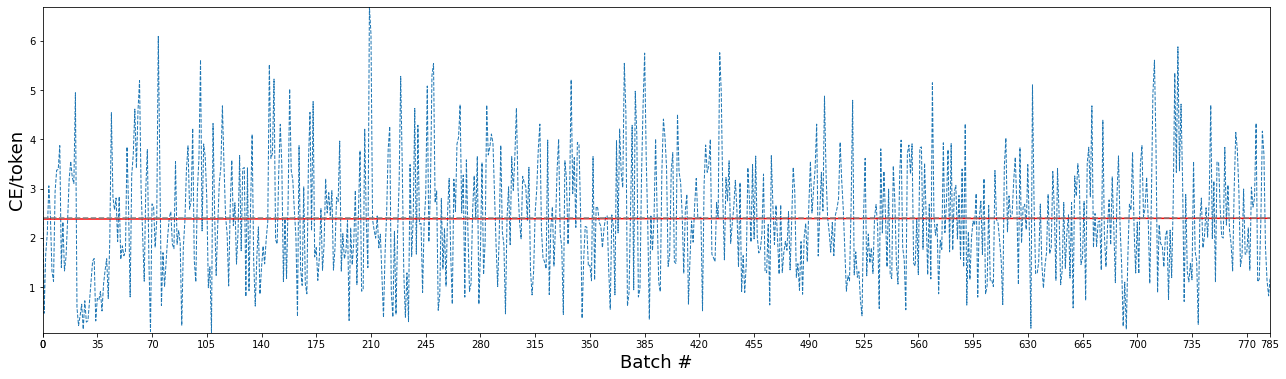

In [ ]:
from utilities import plot_trend

plot_trend(
    range(len(batch_loss.logs)),
    batch_loss.logs,
    'Batch #',
    'CE/token',
    lines=False,
    figsize=(22,6),
    line_style = '--'
)

### Test of model predictions

In [ ]:
from utilities import Translator

translator = Translator(word_to_idx, idx_to_word, word_tk_mem, fun=tf.convert_to_tensor)

out = simplifier(translator.tr("ma questo a cosa servirebbe ?"))
translator.tr(list(zip(*out)))

'ma una complicazione importante . ma'